# Localizing Particles using LodeSTAR

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch06_SelfSupervised/ec06_1_lodestar/lodestar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [1]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00


This notebook provides you with a complete code example that demonstrates how to train and use LodeSTAR to localize particles.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 6-1 from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Creating the Dataset

Define a particle located near the center of the image ...

In [2]:
import deeptrack as dt
from numpy.random import uniform

image_size = 51

particle = dt.PointParticle(
    position=lambda: uniform(image_size / 2 - 5, image_size / 2 + 5, size=2),
)

/usr/local/lib/python3.11/dist-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


... define the optical system as a fluorescence microscope ...

In [3]:
optics = dt.Fluorescence(output_region=(0, 0, image_size, image_size))

... create the  simulation pipeline ...

In [4]:
import torch

simulation = (optics(particle) >> dt.NormalizeMinMax()
              >> dt.Gaussian(sigma=0.1) >> dt.MoveAxis(-1, 0)
              >> dt.pytorch.ToTensor(dtype=torch.float32))

... create the train and test datasets ...

In [5]:
train_dataset = dt.pytorch.Dataset(simulation, length=100)
test_dataset = dt.pytorch.Dataset(simulation & particle.position, length=5000)

... and plot some generated particles and their position.

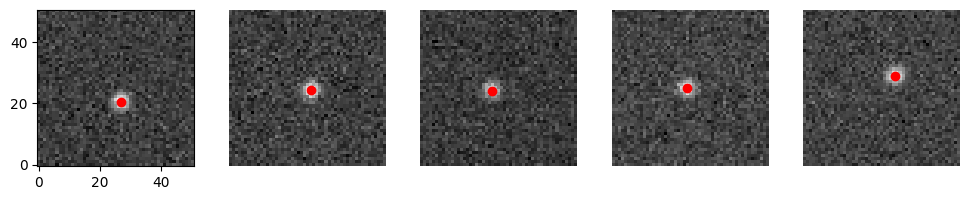

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axs):
    image, position = test_dataset[i]
    ax.imshow(image[0], cmap="gray", origin="lower")
    ax.scatter(position[1], position[0], c="r")
    if i != 0: ax.axis("off")
plt.tight_layout()
plt.show()

## Learning from Translations

Implement a neural network with a convolutional backbone and a dense top layer ...

In [7]:
import deeplay as dl

lodestar = dl.LodeSTAR(optimizer=dl.Adam(lr=1e-4)).build()
model = dl.Sequential(lodestar, torch.nn.Flatten(), torch.nn.LazyLinear(2))

... implement a function to translate the input image ...

In [8]:
from kornia.geometry.transform import translate

def image_translation(batch, translation):
    """Translate a batch of images."""
    xy_flipped_translation = translation[:, [1, 0]]
    return translate(batch, xy_flipped_translation, padding_mode="reflection")

... a function to translate back the output positions ...

In [9]:
def inverse_translation(preds, applied_translation):
    """Invert translation of predicted positions."""
    return preds - applied_translation

... and a class to implement a self-supervised particle localizer trained with translations ...

In [10]:
from torch import rand

class ParticleLocalizer(dl.Application):
    """LodeSTAR implementation with translations."""

    def __init__(self, model, n_transforms=8, **kwargs):
        """Initialize the ParticleLocalizer."""
        self.model, self.n_transforms = model, n_transforms
        super().__init__(**kwargs)

    def forward(self, batch):
        """Forward pass through the model."""
        return self.model(batch)

    def random_arguments(self):
        """Generate random arguments for transformations."""
        return {"translation": \
            (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5)}

    def forward_transform(self, batch, translation):
        """Apply forward translation to the image."""
        return image_translation(batch, translation)

    def inverse_transform(self, preds, translation):
        """Apply inverse translation to the predictions."""
        return inverse_translation(preds, translation)

    def training_step(self, image, batch_idx):
        """Perform a single training step."""
        image, *_ = image
        batch = image.repeat(self.n_transforms, 1, 1, 1)

        kwargs = self.random_arguments()
        transformed_batch = self.forward_transform(batch, **kwargs)

        pred_position = self(transformed_batch)
        pred_position = self.inverse_transform(pred_position, **kwargs)

        average_pred_position = pred_position \
            .mean(dim=0, keepdim=True).repeat(self.n_transforms, 1)
        loss = self.loss(pred_position, average_pred_position)
        self.log("loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

... intantiate this class ...

In [11]:
localizer = ParticleLocalizer(
    model, n_transforms=8, loss=torch.nn.L1Loss(), optimizer=dl.Adam(lr=5e-4),
).create()

... and train the self-supervised particle localizer trained with translations.

In [12]:
dataloader = dl.DataLoader(train_dataset, batch_size=1, shuffle=True)
trainer = dl.Trainer(max_epochs=100)
trainer.fit(localizer, dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/model_summary/model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Sequential       | 251 K  | train
1 | loss          | L1Loss           | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
251 

Training: |          | 0/? [00:00<?, ?it/s]

### Evaluating the Performance

Evaluate the performance of the self-supervised particle localizer trained with translations ...

In [13]:
images, positions = zip(*test_dataset)
images, positions = torch.stack(images), torch.stack(positions)

predictions = localizer(images).detach().numpy()

... implement a function to plot the predicted positions versus the real ones ...

In [14]:
def plot_position_comparison(positions, predictions):
    """Plot comparison between predicted and real particle positions."""
    plt.figure(figsize=(14, 8))
    grid = plt.GridSpec(4, 7, wspace=.2, hspace=.1)

    plt.subplot(grid[1:, :3])
    plt.scatter(positions[:, 0], predictions[:, 0], alpha=.5)
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Horizontal Position", fontsize=20)
    plt.ylabel("Predicted Horizontal Position", fontsize=20)
    plt.axis("equal")

    plt.subplot(grid[1:, 4:])
    plt.scatter(positions[:, 1], predictions[:, 1], alpha=.5)
    plt.axline((25, 25), slope=1, color="black")
    plt.xlabel("True Vertical Position", fontsize=20)
    plt.ylabel("Predicted Vertical Position", fontsize=20)
    plt.axis("equal")

    plt.show()

... and use it to plot the predicted versus real positions.

## Improving the Predictions Averaging Reflected Images

Correct the bias of a self-supervised particle localizer trained with translations.

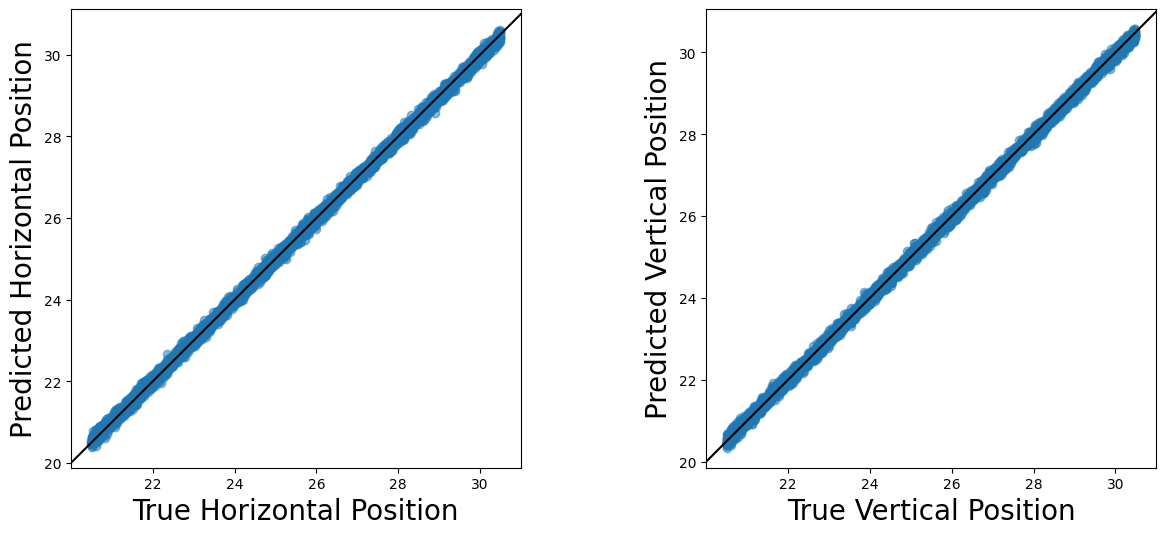

In [16]:
direct_preds = localizer(images).detach().numpy()

flipped_images = images.flip(dims=(2, 3))
flipped_preds = localizer(flipped_images).detach().numpy()

predictions_with_difference = ((direct_preds - flipped_preds) / 2
                               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions_with_difference)

## Learning from Reflections

Implement a function to conditionally reflect images along a specified dimension ...

In [17]:
def flip_transform(batch, should_flip, dim):
    """Conditionally flip batch along a specified dimension."""
    should_flip = should_flip.view(-1, 1, 1, 1)
    return torch.where(should_flip, batch.flip(dims=(dim,)), batch)

... a function to conditionally inverse flip images ...

In [18]:
def inverse_flip_transform(preds, should_flip, dim):
    """Conditionally inverse flip transformation based on should flip."""
    should_flip_mask = torch.zeros_like(preds).bool()
    should_flip_mask[should_flip, dim] = 1
    return torch.where(should_flip_mask, -preds, preds)

... and a class to implement a self-supervised particle localizer trained also with reflections (flips) ...

In [19]:
class ParticleLocalizerWithFlips(ParticleLocalizer):
    """ParticleLocalizer with additional flips."""

    def forward_transform(self, batch, translation, flip_x, flip_y):
        """Apply forward translations and flips to the batch."""
        batch = image_translation(batch, translation)
        batch = flip_transform(batch, flip_x, dim=3)
        batch = flip_transform(batch, flip_y, dim=2)
        return batch

    def inverse_transform(self, preds, translation, flip_x, flip_y):
        """Apply the inverse transformation to the predictions."""
        preds = inverse_flip_transform(preds, flip_x, dim=1)
        preds = inverse_flip_transform(preds, flip_y, dim=0)
        preds = inverse_translation(preds, translation)
        return preds

    def random_arguments(self):
        """Generate random arguments for translations and flips."""
        return {"translation": \
            (rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5),
            "flip_x": rand(self.n_transforms).float().to(self.device) > 0.5,
            "flip_y": rand(self.n_transforms).float().to(self.device) > 0.5}

... train a self-supervised particle localizer with flipping transformations ...

In [20]:

localizer_with_flips = ParticleLocalizerWithFlips(
    model, n_transforms=8, loss=torch.nn.L1Loss(), optimizer=dl.Adam(lr=1e-3),
).create()

trainer_with_flips = dl.Trainer(max_epochs=100)
trainer_with_flips.fit(localizer_with_flips, dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Sequential       | 251 K  | train
1 | loss          | L1Loss           | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
48        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

... and plot the predictions versus real positions for a self-supervised particle localizer with reflections.

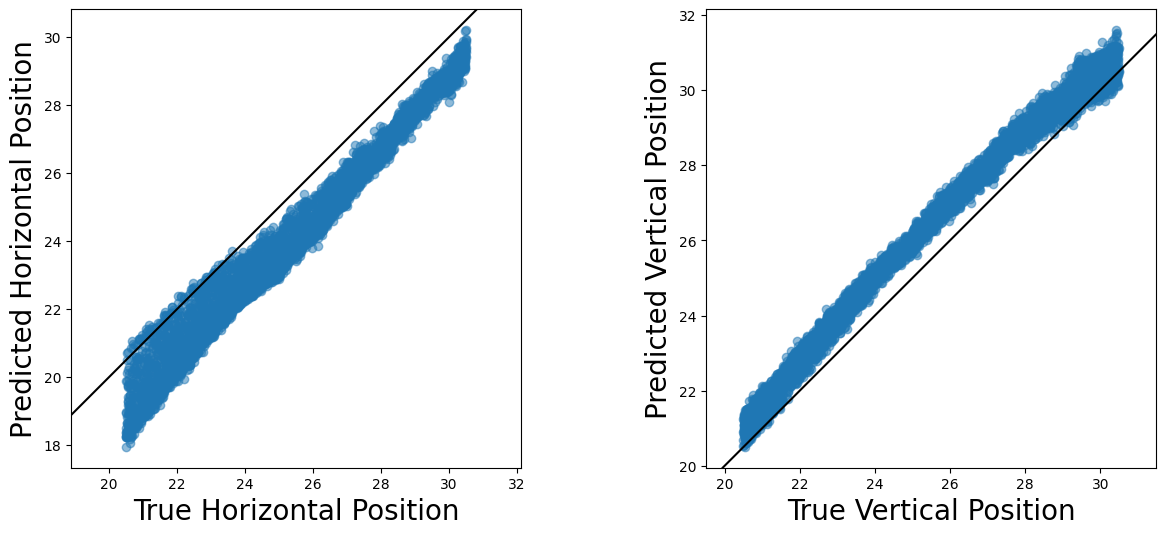

In [21]:
predictions = (localizer_with_flips(images).detach().numpy()
               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions)

Rotation

In [22]:
import torch

def rotate_transform(batch, angles, center=None):
    """Rotate each image in the batch by its specified angle around the given center."""

    batch_size, channels, height, width = size_tuple = tuple(batch.size())
    if center is None:
        center = (height // 2, width // 2)

    rotated_batch = torch.empty_like(batch)

    for i in range(batch_size):
        angle_rad = angles[i] * torch.pi / 180
        rotation_matrix = torch.tensor([
            [torch.cos(angle_rad), -torch.sin(angle_rad), 0],
            [torch.sin(angle_rad), torch.cos(angle_rad), 0]
        ], device=batch.device, dtype=torch.float32)

        grid = torch.nn.functional.affine_grid(
            rotation_matrix.unsqueeze(0), batch[i:i+1].size(), align_corners=False
        )

        rotated_batch[i:i+1] = torch.nn.functional.grid_sample(batch[i:i+1], grid, align_corners=False)
    return rotated_batch


In [23]:
def inverse_rotate_transform(preds, angles, center=None):
    """Inverse rotate transformation for each (x, y) coordinate in the batch."""

    batch_size = preds.size(0)
    rotated_preds = torch.empty_like(preds)

    for i in range(batch_size):
        # Convert angle to radians and negate it for inverse rotation
        angle_rad = angles[i] * torch.pi / 180

        # Define the rotation matrix for inverse rotation
        rotation_matrix = torch.tensor([
            [torch.cos(angle_rad), torch.sin(angle_rad)],
            [-torch.sin(angle_rad), torch.cos(angle_rad)]
        ], device=preds.device, dtype=preds.dtype)

        # If a center is provided, translate coordinates to origin
        if center is not None:
            preds[i] = preds[i] - center

        # Apply the rotation matrix to the (x, y) pair
        rotated_preds[i] = preds[i] @ rotation_matrix.T

        # Translate back if a center was provided
        if center is not None:
            rotated_preds[i] = rotated_preds[i] + center

    return rotated_preds

In [24]:
class ParticleLocalizerWithRotation(ParticleLocalizer):
    """ParticleLocalizer with additional flips."""

    def forward_transform(self, batch, translation, rotation_angle):
        """Apply forward translations and rotations to the batch."""
        batch = image_translation(batch, translation)
        batch = rotate_transform(batch, rotation_angle)
        return batch

    def inverse_transform(self, preds, translation, rotation_angle):
        """Apply the inverse transformation to the predictions."""
        preds = inverse_rotate_transform(preds, rotation_angle)
        preds = inverse_translation(preds, translation)
        return preds


    def random_arguments(self):
        """Generate random arguments for translations and flips."""
        return {
            "translation": (torch.rand(self.n_transforms, 2).float().to(self.device) * 5 - 2.5),
            "rotation_angle": torch.rand(self.n_transforms).float().to(self.device) * 360
        }

In [25]:
localizer_with_rotation = ParticleLocalizerWithRotation(
    model, n_transforms=8, loss=torch.nn.L1Loss(), optimizer=dl.Adam(lr=1e-3),
).create()
trainer_with_flips = dl.Trainer(max_epochs=100)
trainer_with_flips.fit(localizer_with_rotation, dataloader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | Sequential       | 251 K  | train
1 | loss          | L1Loss           | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
251 K     Trainable params
0         Non-trainable params
251 K     Total params
1.004     Total estimated model params size (MB)
48        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
----------------------

Training: |          | 0/? [00:00<?, ?it/s]

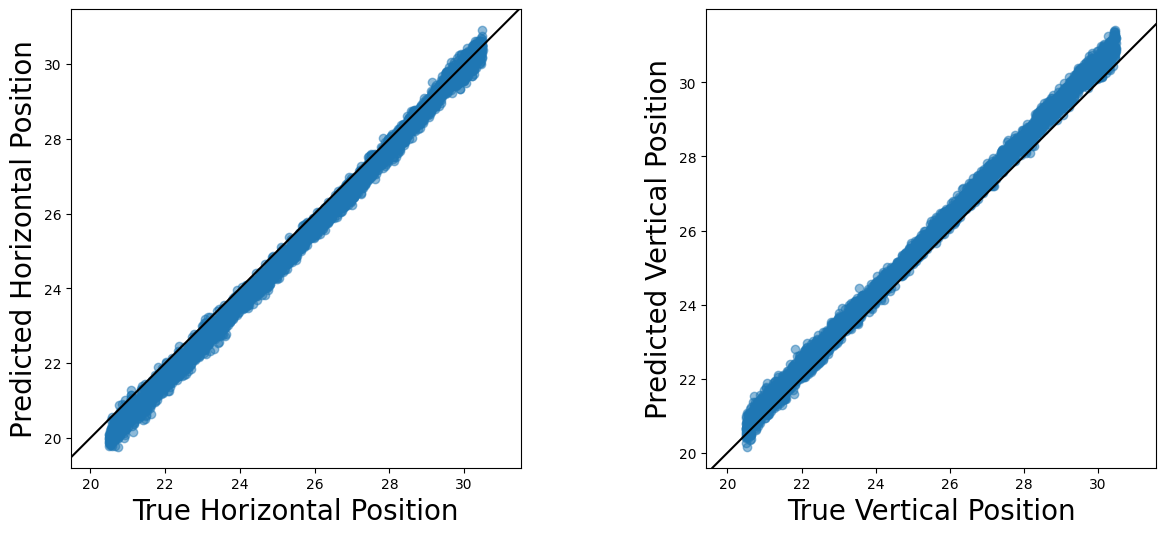

In [26]:
predictions = (localizer_with_rotation(images).detach().numpy()
               + image_size / 2 - 0.5)

plot_position_comparison(positions, predictions)